International Monetary Fund API with Python
=====

I'd suggest first looking at my website's [guide](https://www.bd-econ.com/imfapi1.html) to using the IMF API. 


IMF API Documentation is [here](http://datahelp.imf.org/knowledgebase/articles/667681-json-restful-web-service)

In [1]:
# Python 3.11
import requests
import pandas as pd
import json

#### Parameters/ Settings

In [2]:
dataset_id = {'BOP' : 'Balance of Payments', 'CPI' : 'Consumer price index', 
              'CPIS' : 'Coordinated Portfolio Investment Survey', 'COFER': 'Currency Composition of Official Foreign Exchange Reserves', 'DOT' : 'Direction of Trade Statistics', 'FAS': 'Financial Access Survey', 'FSI': 'Financial Soundness Indicators', 'FM': 'Fiscal Monitor', 'HPDD':'Historical Public Debt','IFS':'International Financial Statistics', 'IRFCL':'International Reserves and Foreign Currency Liquidity','MCDREO':'Middle East and Central Asia Regional Economic Outlook', 'MFS':'Monetary and Financial Statistics'}

In [27]:
def get_country_code(database_id):
    response = requests.get(f'http://dataservices.imf.org/REST/SDMX_JSON.svc/DataStructure/{database_id}').json()
    codes = response['Structure']["CodeLists"]['CodeList'][2]['Code']
    country_code = {"code":[], 'country':[]}
    for i in codes:
        country_code['code'].append(i['@value'])
        country_code['country'].append(i['Description']['#text'])
    countries = pd.DataFrame(country_code)
    return countries
def get_indicator_id(database_id):
    response = requests.get(f'http://dataservices.imf.org/REST/SDMX_JSON.svc/DataStructure/{database_id}').json()
    codes = response['Structure']["CodeLists"]['CodeList'][3]['Code']
    id = {"id": [], 'name' : []}
    for i in codes:
        key = i['@value']
        values = i['Description']['#text'].split(',')
        id['id'].append(key)
        id['name'].append(values)
    indicator_id =  pd.DataFrame(id)
    return indicator_id


In [4]:
# Go to IMF homepage to get dataset ID 
# Use dataset ID and add to below url to get datastructure 
# http://dataservices.imf.org/REST/SDMX_XML.svc/DataStructure/CPI 
# Use datastructure to get elements for url requests

In [ ]:


      # df = pd.DataFrame({s['@REF_AREA']: # Each country/area
      #                   {(i['@TIME_PERIOD']: float(i['@OBS_VALUE']), 'unit' : i['@UNIT_MULT'])
      #                   for i in s['Obs']} for s in data})

      # # Convert index to datetime
      # df.index = pd.to_datetime(df.index)
      # df = df.reset_index()
      # df_long = pd.melt(df, id_vars=['index'], var_name='country', value_name='data')

#### Get data from api

In [94]:
def get_data_api(dataset_id, freq, country_list, indicator_id,startPeriod):
      # ('dataset', 'CPI'), ('freq', 'M'),('country', 'BR+CN+FR'),('indicator_id', 'PCPI_IX'),('start', '?startPeriod=2009')
      countries = "+".join(i for i in country_list)
      url = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/'
      param = [('dataset', f'{dataset_id}'),
            ('freq', f'{freq}'),
            ('country', f'{countries}'),
            ('indicator_id', f'{indicator_id}'),
            ('start', f'?startPeriod={startPeriod}')]
      series = '.'.join([i[1] for i in param[1:4]])
      key = f'CompactData/{param[0][1]}/{series}{param[-1][1]}'
      # Combine API url with key specific to data request
      r = requests.get(f'{url}{key}').json()
      # data portion of results
      data = r['CompactData']['DataSet']['Series']
      # Create a dictionary to store the data
      data_dict = {}
      for s in data:
            country = s['@REF_AREA']
            observations = s['Obs']
            data_dict[country] = {obs['@TIME_PERIOD']: float(obs['@OBS_VALUE']) for obs in observations}
            data_dict['unit'] = s['@UNIT_MULT']
      # Create a pandas DataFrame from the dictionary
      df = pd.DataFrame(data_dict)
      
      # Convert the index to datetime
      df.index = pd.to_datetime(df.index)
      
      # Reset the index and convert the DataFrame to long format
      df = df.reset_index().rename(columns={'index': 'date'})
      df_long = pd.melt(df, id_vars=['date', 'unit'], var_name='country', value_name='data')
      
      return df_long

In [95]:
df = get_data_api('CPI', 'M', ['BR', 'CN'], 'PCPI_IX', 2010 )

------

## Metadata and param lookup examples

#### Find available series by search term

In [61]:
url = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/'
key = 'Dataflow'  # Method with series information
t = 'Consumer'  # Term to find in series names
sl = requests.get(f'{url}{key}').json()['Structure']['Dataflows']['Dataflow']
# Print list of series containing text t
for s in (s for s in sl if t in s['Name']['#text']): 
    code = s['KeyFamilyRef']['KeyFamilyID']
    print(f"{s['Name']['#text']}: {code}")

Consumer Price Index (CPI): CPI


#### Print the dimensions for a given series, use series get above to replace key

In [71]:
dataset_id = 'CPI'
key_1 = f'DataStructure/{dataset_id}'  # Method / series
dl = requests.get(f'{url}{key_1}').json()\
    ['Structure']['KeyFamilies']['KeyFamily']['Components']['Dimension']
for n, d in enumerate(dl):
    print(f"Dimension {n+1}: {d['@codelist']}")

Dimension 1: CL_FREQ
Dimension 2: CL_AREA_CPI
Dimension 3: CL_INDICATOR_CPI


#### See what values are acceptable for dimension above

In [65]:
# Example: codes for dimension 3
key_3 = f"CodeList/{dl[2]['@codelist']}"
cl = requests.get(f'{url}{key_3}').json()['Structure']['CodeLists']['CodeList']['Code']
for c in cl:
    print(f"{c['Description']['#text']}: {c['@value']}")

Consumer Price Index, All items: PCPI_IX
Food and non-alcoholic beverages: PCPIF_IX
Alcoholic Beverages, Tobacco, and Narcotics: PCPIFBT_IX
Clothing and footwear: PCPIA_IX
Housing, Water, Electricity, Gas and Other Fuels: PCPIH_IX
Furnishings, household equipment and routine household maintenance: PCPIHO_IX
Health: PCPIM_IX
Transport: PCPIT_IX
Communication: PCPIEC_IX
Recreation and culture: PCPIR_IX
Education: PCPIED_IX
Restaurants and hotels: PCPIRE_IX
Miscellaneous goods and services: PCPIO_IX
Consumer Price Index, All items, Overlap: PCPI_OLP_IX
Food and non-alcoholic beverages, Overlap: PCPIF_OLP_IX
Alcoholic Beverages, Tobacco, and Narcotics, Overlap: PCPIFBT_OLP_IX
Clothing and footwear, Overlap: PCPIA_OLP_IX
Housing, Water, Electricity, Gas and Other Fuels, Overlap: PCPIH_OLP_IX
Furnishings, household equipment and routine household maintenance, Overlap: PCPIHO_OLP_IX
Health, Overlap: PCPIM_OLP_IX
Transport, Overlap: PCPIT_OLP_IX
Communication, Overlap: PCPIEC_OLP_IX
Recreation

#### Bad example for how to get metadata

Probably better to just print the text, m, and read it.

In [9]:
key = 'GenericMetadata/IFS/M.GB.PMP_IX'
m = requests.get(f'{url}{key}').json()['GenericMetadata']['MetadataSet']['AttributeValueSet']
country = m[1]['ReportedAttribute'][1]['ReportedAttribute'][3]['Value']['#text']
indicator = m[2]['ReportedAttribute'][1]['ReportedAttribute'][3]['Value']['#text']
print(f'Country: {country}; Indicator: {indicator}')

Country: United Kingdom; Indicator: Prices, Import Price Index, All Commodities, Index


#### Another example

In [10]:
%matplotlib inline

import matplotlib
from matplotlib import pyplot as plt
#import seaborn
matplotlib.rc('axes',edgecolor='w')

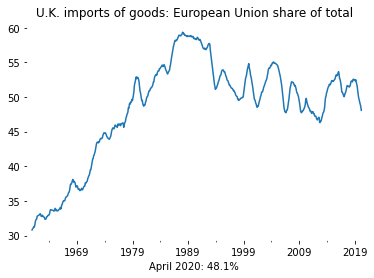

In [11]:
import pandas as pd           # pandas version 0.18.1

# key includes two partners, B0 and W00 for EU and world
key = 'CompactData/DOT/M.GB.TMG_CIF_USD.B0+W00'

# Retrieve data from IMF API
data = requests.get(f'{url}{key}').json()

# Convert results to pandas dataframe
df = pd.DataFrame({s['@COUNTERPART_AREA'] : {pd.to_datetime(i['@TIME_PERIOD']) : 
     round(float(i['@OBS_VALUE']), 1) for i in s['Obs']} 
     for s in data['CompactData']['DataSet']['Series']})

# 12 month moving average of EU share of total
eu_share = (df['B0'].div(df['W00']) * 100).rolling(12).mean()

# Create a line plot and print most recent value as x label
title = "U.K. imports of goods: European Union share of total"
recent = f"{eu_share.index[-1].strftime('%B %Y')}: {eu_share[-1].round(1)}%"
ax = eu_share.plot(title=title)
ax = ax.set_xlabel(recent)